# Inpainting Flu Dynamics Forecasts
Based on _The annotated diffusion model_ from Niels Rogge and Kashif Rasul at Hugging Face. More information and annotations are found on `dev/HF-annotated-diffusion-ref.ipynb`

In [2]:
import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

/Users/chadi/opt/miniconda3/envs/diffusion_torch/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## The neural network
### Network helpers
First, we define some helper functions and classes which will be used when implementing the neural network. Importantly, we define a `Residual` module, which simply adds the input to the output of a particular function (in other words, adds a residual connection to a particular function).

We also define aliases for the up- and downsampling operations.

In [3]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

### Position embeddings
The `SinusoidalPositionEmbeddings` module takes a tensor of shape `(batch_size, 1)` as input (i.e. the noise levels of several noisy images in a batch), and turns this into a tensor of shape `(batch_size, dim)`, with `dim` being the dimensionality of the position embeddings. This is then added to each residual block, as we will see further.

In [3]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

### ResNet/ConvNeXT block

Next, we define the core building block of the U-Net model. The DDPM authors employed a Wide ResNet block ([Zagoruyko et al., 2016](https://arxiv.org/abs/1605.07146)), but Phil Wang decided to also add support for a ConvNeXT block ([Liu et al., 2022](https://arxiv.org/abs/2201.03545)), as the latter has achieved great success in the image domain. One can choose one or another in the final U-Net architecture.

In [4]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

### Attention module

Next, we define the attention module, which the DDPM authors added in between the convolutional blocks. Attention is the building block of the famous Transformer architecture ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)), which has shown great success in various domains of AI, from NLP and vision to [protein folding](https://www.deepmind.com/blog/alphafold-a-solution-to-a-50-year-old-grand-challenge-in-biology). Phil Wang employs 2 variants of attention: one is regular multi-head self-attention (as used in the Transformer), the other one is a [linear attention variant](https://github.com/lucidrains/linear-attention-transformer) ([Shen et al., 2018](https://arxiv.org/abs/1812.01243)), whose time- and memory requirements scale linear in the sequence length, as opposed to quadratic for regular attention.

For an extensive explanation of the attention mechanism, we refer the reader to Jay Allamar's [wonderful blog post](https://jalammar.github.io/illustrated-transformer/).

In [5]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

### Group normalization

The DDPM authors interleave the convolutional/attention layers of the U-Net with group normalization ([Wu et al., 2018](https://arxiv.org/abs/1803.08494)). Below, we define a `PreNorm` class, which will be used to apply groupnorm before the attention layer, as we'll see further. Note that there's been a [debate](https://tnq177.github.io/data/transformers_without_tears.pdf) about whether to apply normalization before or after attention in Transformers.

In [6]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

### Conditional U-Net

Now that we've defined all building blocks (position embeddings, ResNet/ConvNeXT blocks, attention and group normalization), it's time to define the entire neural network. Recall that the job of the network \\(\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)\\) is to take in a batch of noisy images + noise levels, and output the noise added to the input. More formally:

- the network takes a batch of noisy images of shape `(batch_size, num_channels, height, width)` and a batch of noise levels of shape `(batch_size, 1)` as input, and returns a tensor of shape `(batch_size, num_channels, height, width)`

The network is built up as follows:
* first, a convolutional layer is applied on the batch of noisy images, and position embeddings are computed for the noise levels
* next, a sequence of downsampling stages are applied. Each downsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + a downsample operation
* at the middle of the network, again ResNet or ConvNeXT blocks are applied, interleaved with attention
* next, a sequence of upsampling stages are applied. Each upsampling stage consists of 2 ResNet/ConvNeXT blocks + groupnorm + attention + residual connection + an upsample operation
* finally, a ResNet/ConvNeXT block followed by a convolutional layer is applied.

Ultimately, neural networks stack up layers as if they were lego blocks (but it's important to [understand how they work](http://karpathy.github.io/2019/04/25/recipe/)).


In [7]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

## Defining the forward diffusion process

The forward diffusion process gradually adds noise to an image from the real distribution, in a number of time steps $T$. This happens according to a **variance schedule**. The original DDPM authors employed a linear schedule:

> We set the forward process variances to constants
increasing linearly from $\beta_1 = 10^{−4}$
to $\beta_T = 0.02$.

However, it was shown in ([Nichol et al., 2021](https://arxiv.org/abs/2102.09672)) that better results can be achieved when employing a cosine schedule. 

Below, we define various schedules for the $T$ timesteps, as well as corresponding variables which we'll need, such as cumulative variances.

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

To start with, let's use the linear schedule for \\(T=200\\) time steps and define the various variables from the \\(\beta_t\\) which we will need, such as the cumulative product of the variances \\(\bar{\alpha}_t\\). Each of the variables below are just 1-dimensional tensors, storing values from \\(t\\) to \\(T\\). Importantly, we also define an `extract` function, which will allow us to extract the appropriate \\(t\\) index for a batch of indices.


In [9]:
timesteps = 200

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

We'll illustrate with a cats image how noise is added at each time step of the diffusion process.

In [14]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

Let's test it on a particular time step:

In [15]:
def get_noisy_image(x_start, t):
  # add noise
  x_noisy = q_sample(x_start, t=t)

  # turn back into PIL image
  noisy_image = reverse_transform(x_noisy.squeeze())

  return noisy_image

In [ ]:
# take time step
t = torch.tensor([40])

get_noisy_image(x_start, t)

In [17]:
import matplotlib.pyplot as plt

# use seed for reproducability
torch.manual_seed(0)

# source: https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py
def plot(imgs, with_orig=False, row_title=None, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0]) + with_orig
    fig, axs = plt.subplots(figsize=(200,200), nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        row = [image] + row if with_orig else row
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    if with_orig:
        axs[0, 0].set(title='Original image')
        axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])

    plt.tight_layout()

In [ ]:
plot([get_noisy_image(x_start, torch.tensor([t])) for t in [0, 50, 100, 150, 199]])

This means that we can now define the loss function given the model as follows:

In [19]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

The `denoise_model` will be our U-Net defined above. We'll employ the Huber loss between the true and the predicted noise.

## Define a PyTorch Dataset + DataLoader


In [21]:
import xarray as xr
a = xr.open_dataarray('datasets/from_csp_weekly_pad_4scn.nc').to_numpy()
a.shape

(1199, 3, 64, 64)

created dataset with scale [13575.0726171   5368.98319629    17.73463991]


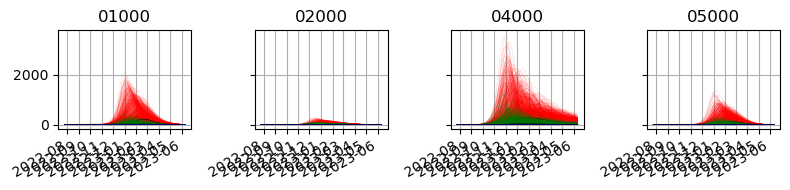

In [22]:
import xarray as xr
from torch.utils.data import DataLoader

image_size = 64
channels = 3
batch_size = 128


def show_curves(datset, grid=(1,4)):
    fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
    for i, ax in enumerate(axes.flat):
        c = ['red', 'green', 'blue']
        place = datset.get_index('place')[i]
        tp = datset.sel(place=place)
        for k, val in enumerate(datset.feature):
            ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
            ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                    c = 'k',#'dark'+c[k], 
                    lw = .5, 
                    alpha=1)
        ax.grid()
        ax.set_title(place)
    fig.autofmt_xdate()
    fig.tight_layout()
    
class FluDynamicsSyntheticDataset(torch.utils.data.Dataset):
    def __init__(self, netcdf_file, transform=None):
        """
        Args:
            netcdf_file (string): Path to the netcdf file with the xarray data
            transform (callable, optional): Optional transform to be applied
            on a sample.
        """
        self.flu_dyn = xr.open_dataarray(netcdf_file)
        self.transform = transform
        
        #if channels = 1:
        #    self.flu_dyn=self.flu_dyn.isel(feature=0)
        
        # let's store the min and max
        self.max_per_feature = self.flu_dyn.max(dim=["date", "place", "sample"])
        print(f"created dataset with scale {np.array(self.max_per_feature)}")
        self.flu_dyn_norm = (np.sqrt(self.flu_dyn)/np.sqrt(self.max_per_feature))*2#-1
        
        
    def __len__(self):
        return len(self.flu_dyn.sample)
    
    def __getitem__(self, idx):
        frame, idx = self.getitem_nocast(idx)
        return torch.from_numpy(frame).float(), idx
    
    def getitem_nocast(self, idx):
        if torch.is_tensor(idx):
            idxl = idx.tolist()
        else:
            idxl=idx
            
        epi_frame = self.flu_dyn_norm.sel(sample=idxl).squeeze().to_numpy()#.astype(np.float32)

        #shoudle be a dict ?
        #sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            epi_frame = self.transform(epi_frame)

        return epi_frame, idx
    
    def unnormalized(self, array):
        #return (((array)/3)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
        return (((array)/2)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
        #return ((array+.75)*np.sqrt((self.max_per_feature.to_numpy())[:,np.newaxis, np.newaxis]))**2
    
    def test(self, idx):
        """
        test that we can transform and go back & get the same thing
        """
        epi_frame_n, idx_n = self.getitem_nocast(idx)
        assert idx_n == idx
        #print(self.unnormalized(epi_frame_n).shape, self.unnormalized(epi_frame_n)[0,0,0])
        #print(self.flu_dyn.sel(sample=idx).shape, self.flu_dyn.sel(sample=idx)[0,0,0])
        assert (np.abs(self.unnormalized(epi_frame_n) - self.flu_dyn.sel(sample=idx)) < 1e-3).all()
    

flu_dyn = xr.open_dataarray('datasets/from_csp_weekly_pad_4scn.nc')#.to_array(name='from_csp') #torchvision.datasets.StanfordCars(root=".", download=True)
show_curves(flu_dyn)
dates= list(flu_dyn.date.values)
places=list(flu_dyn.place.values)
features=list(flu_dyn.feature.values)

data = FluDynamicsSyntheticDataset('datasets/from_csp_weekly_pad_4scn.nc')
data.test(7)
data.test(19)

dataloader = DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True) # Dataset is shuffled, but the last incompleted batch is dropped

Next, we define a function which we'll apply on-the-fly on the entire dataset. We use the `with_transform` [functionality](https://huggingface.co/docs/datasets/v2.2.1/en/package_reference/main_classes#datasets.Dataset.with_transform) for that. The function just applies some basic image preprocessing: random horizontal flips, rescaling and finally make them have values in the $[-1,1]$ range.

In [23]:
from torchvision import transforms
from torch.utils.data import DataLoader

## define image transformations (e.g. using torchvision)
#transform = Compose([
#            transforms.RandomHorizontalFlip(),
#            transforms.ToTensor(),
#            transforms.Lambda(lambda t: (t * 2) - 1)
#])

# define function
#def transforms(examples):
#   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
#   del examples["image"]

#   return examples

#transformed_dataset = dataset.with_transform(transforms).remove_columns("label")

# create dataloader
#dataloader = DataLoader(transformed_dataset["train"], batch_size=batch_size, shuffle=True)

In [24]:
batch = next(iter(dataloader))
print(batch[0].shape, "\n", batch[1])

torch.Size([128, 3, 64, 64]) 
 tensor([1074,  462, 1036,   64, 1135, 1037,  804,  894,  916,  528,  498, 1141,
         688,  860,   83,   95,  583,  456,  765, 1080, 1025,  230,  530,  706,
         246,   78, 1159,  806,  606,  972, 1004,  584,   89,  306,  224,  578,
         247,  610,  659,  467,   68,   18,  719,  311,  209,  110, 1177,  839,
          96,  514,  580,  737,  934,  154, 1127,  144,  855,  481,  577, 1107,
        1091,  406,  878,  660,  801,  196, 1043,  402,  473,  347,   59,  331,
         564,  856,  484, 1078,  652,  614,  607,  816,  276,  825,  316,  763,
         685,   60,  705, 1035,  505,   80,  727,  736,  352, 1053,  533,  495,
         242,  889,   71,  502,  755, 1147,  409, 1155,  532,  741,  667, 1142,
         244,   97,  975,  979,  786,  269,  243,  148,  924,  866,  258,  169,
         264,  998,   66,  740,  392,  444,  534, 1160])


## Sampling

In [25]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

## Train the model


In [26]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 1000

In [27]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,),
    use_convnext=False
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

cuda


In [28]:
from torchvision.utils import save_image

epochs = 300

for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      #batch_size = batch["pixel_values"].shape[0]
      #batch = batch["pixel_values"].to(device)
      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      loss = p_losses(model, batch, t,  loss_type="huber") #loss_type="l2")#

      if step % 100 == 0:
        print(f"Epoch: {epoch} -- Loss: {loss.item()}")

      loss.backward()
      optimizer.step()

      # save generated images
      if step != 0 and step % save_and_sample_every == 0:
        milestone = step // save_and_sample_every
        batches = num_to_groups(4, batch_size)
        all_images_list = list(map(lambda n: sample(model, batch_size=n, channels=channels), batches))
        all_images = torch.cat(all_images_list, dim=0)
        all_images = (all_images + 1) * 0.5
        save_image(all_images, str(results_folder / f'sample-{milestone}.png'), nrow = 6)


Epoch: 0 -- Loss: 0.4731054902076721
Epoch: 1 -- Loss: 0.45840805768966675
Epoch: 2 -- Loss: 0.4285401701927185
Epoch: 3 -- Loss: 0.42432475090026855
Epoch: 4 -- Loss: 0.4231754243373871
Epoch: 5 -- Loss: 0.420185387134552
Epoch: 6 -- Loss: 0.417151540517807
Epoch: 7 -- Loss: 0.40481647849082947
Epoch: 8 -- Loss: 0.3800323009490967
Epoch: 9 -- Loss: 0.3319275975227356
Epoch: 10 -- Loss: 0.2845742106437683
Epoch: 11 -- Loss: 0.22510817646980286
Epoch: 12 -- Loss: 0.17766070365905762
Epoch: 13 -- Loss: 0.140895813703537
Epoch: 14 -- Loss: 0.10924943536520004
Epoch: 15 -- Loss: 0.07450595498085022
Epoch: 16 -- Loss: 0.05039706453680992
Epoch: 17 -- Loss: 0.04201211780309677
Epoch: 18 -- Loss: 0.041818033903837204
Epoch: 19 -- Loss: 0.03459712117910385
Epoch: 20 -- Loss: 0.02931390330195427
Epoch: 21 -- Loss: 0.029291749000549316
Epoch: 22 -- Loss: 0.02719544619321823
Epoch: 23 -- Loss: 0.02588944509625435
Epoch: 24 -- Loss: 0.03959406912326813
Epoch: 25 -- Loss: 0.026846993714571
Epoch: 2

## Sampling (inference)

To sample from the model, we can just use our sample function defined above:


In [29]:
# sample 64 images
samples = sample(model, image_size=image_size, batch_size=batch_size, channels=channels) # coul batch_size be different ?

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


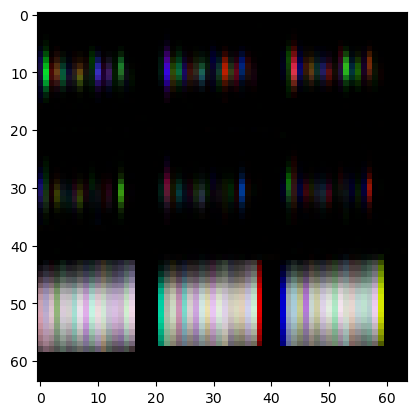

In [30]:
# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels))

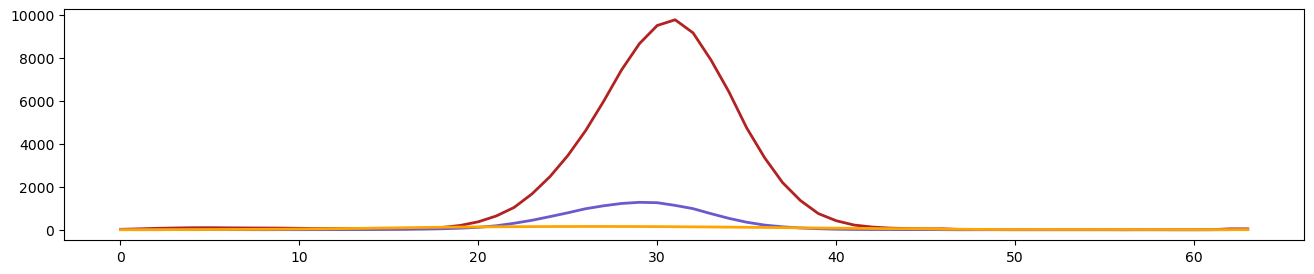

In [31]:
def plot_to_ax(array, ax=None, place=None, multi=False):
    c = ['firebrick', 'slateblue', 'orange']
    # (3, 48, 51)
    if len(array.shape) == 4: # it's a batch
        array = array[0, :, :, :] 
    if ax is None:
        ax = plt.gca() # get current ax
        
    if place is None:
        array_to_plot = array.sum(axis=2)
    else:
        array_to_plot = array[:, :, place]
    for k in range(channels):
        if multi: # several lines will be plotted:
            ax.plot(array_to_plot[k], c = c[k], lw = .5, alpha=.5)
        else:
            ax.plot(array_to_plot[k], c = c[k], lw = 2, alpha=1)
        
def show_tensor_image(image, ax=None, place=None, multi=False):
    plot_to_ax(data.unnormalized(image), ax=ax, place=place, multi=multi)
    
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
show_tensor_image(samples[-1][random_index], ax = ax)
plt.show()

In [32]:
samples[-1][random_index].shape

(3, 64, 64)

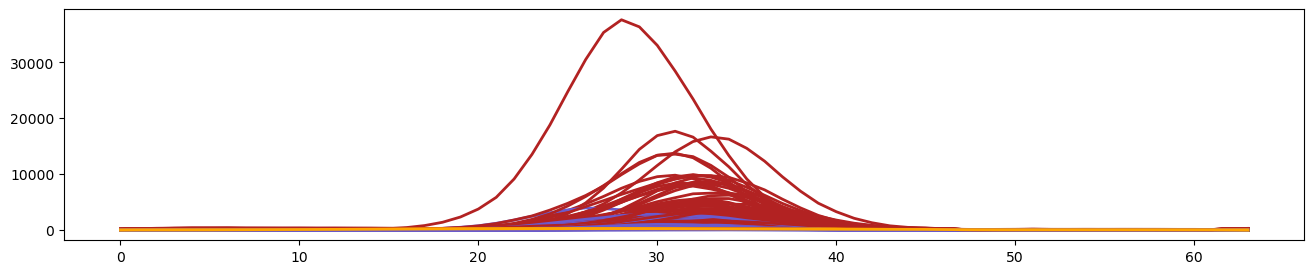

In [33]:
fig, axes = plt.subplots(1, 1, figsize=(16,3), dpi=100)
ax = axes # es.flat[i]
for i in range(batch_size):
    show_tensor_image(samples[-1][i], ax = ax)

#ax.set_ylim(0,10000)

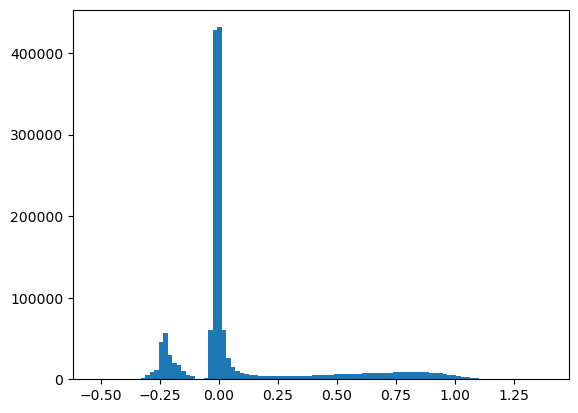

In [34]:
plt.hist(samples[-1].flatten(), bins = 100);

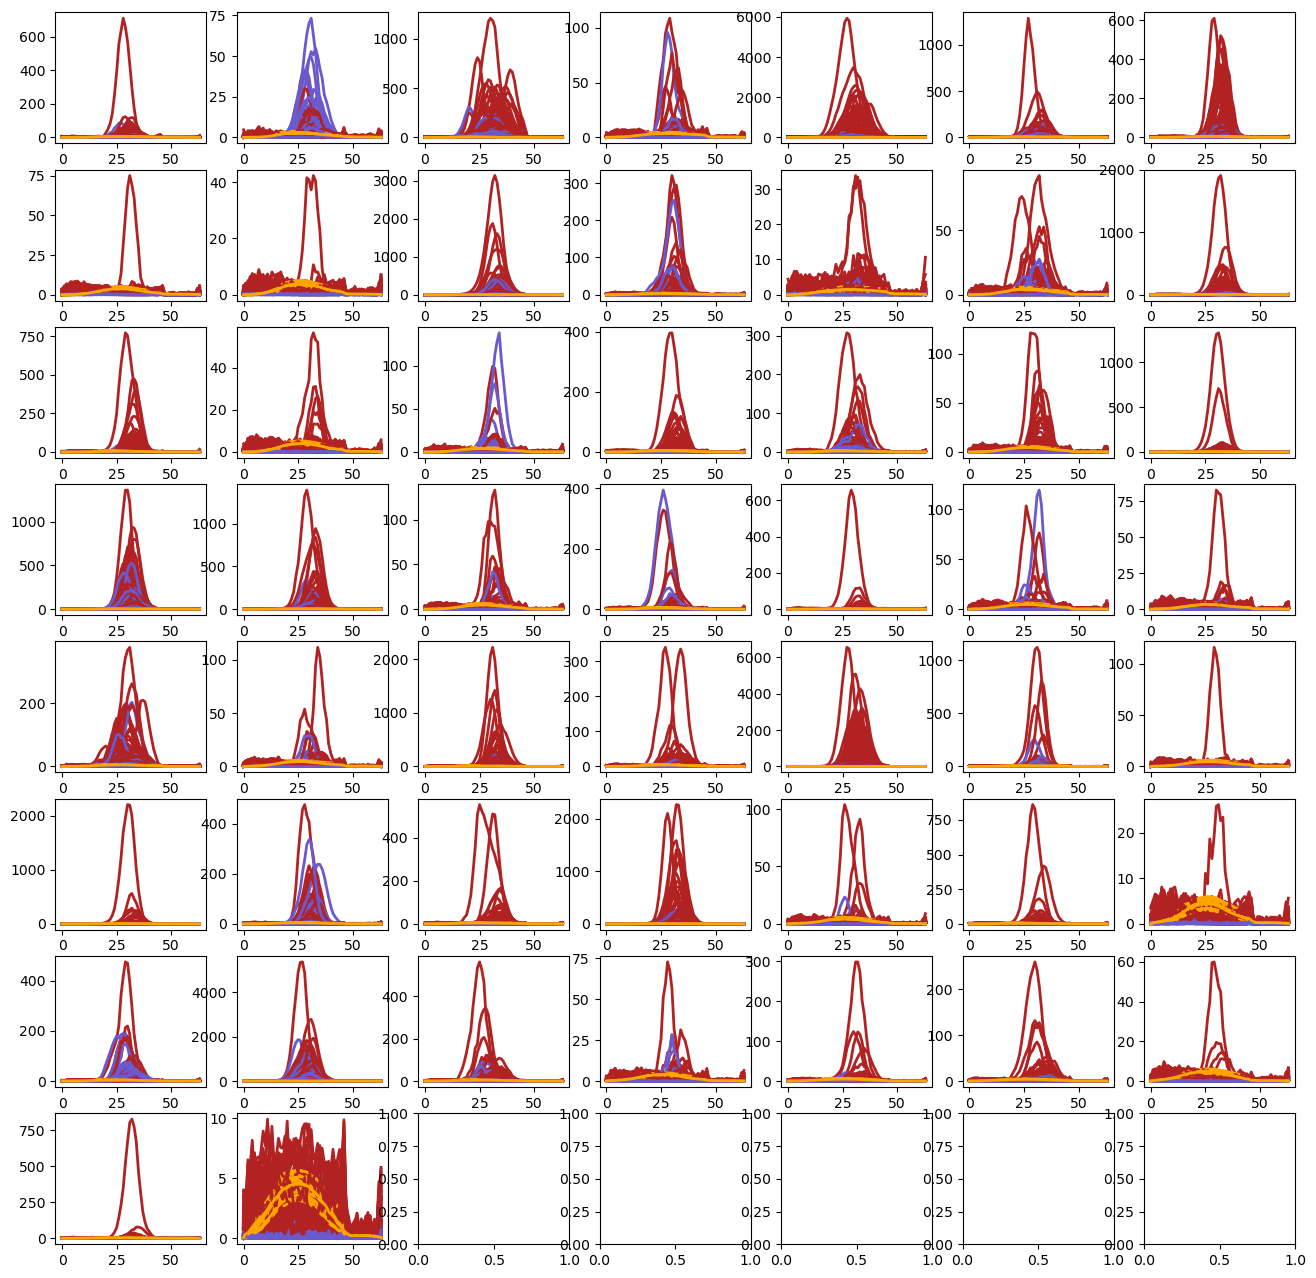

In [35]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=100)

for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(batch_size):
        show_tensor_image(samples[-1][i], ax = ax, place=ipl)


In [36]:
animate = False
if animate:
    import matplotlib.animation as animation

    random_index = 53
# TODO: the reshape shuffles the information
    fig = plt.figure()
    ims = []
    for i in range(timesteps):
        im = plt.imshow(samples[i][random_index].reshape(image_size, image_size, channels), animated=True)
        ims.append([im])

    animate = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    animate.save('diffusion.gif')
    plt.show()

In [37]:
if animate:
    plt.ioff()
    for ts in tqdm(range(0, timesteps, 5)):
        fig, axes = plt.subplots(8, 8, figsize=(10,10))
        for ipl in range(51):
            ax = axes.flat[ipl]
            for i in range(0,batch_size, 2):
                show_tensor_image(samples[ts][i], ax = ax, place=ipl)
        plt.savefig(f'results/{ts}.png')
        plt.close(fig)

## Let's add repainting from the RePaint paper

Dimensions are chanel, time, place

In [38]:
gt_index = 19

In [39]:
gt_keep_mask = np.ones((channels,image_size,image_size))
# mask is ones for the known pixels, and zero for the ones to be infered

In [40]:
gt_keep_mask[:,gt_index:,:] = 0

(3, 64, 64)


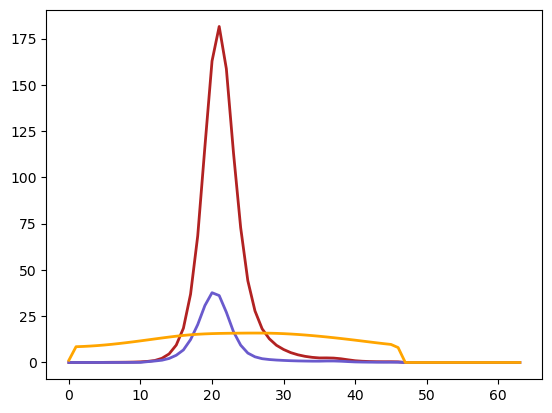

In [41]:
gt, idx = data.getitem_nocast(4)
print(gt.shape)
show_tensor_image(gt, place=ipl)
plt.show()

In [42]:
device = next(model.parameters()).device
gt_keep_mask = torch.from_numpy(gt_keep_mask).type(torch.FloatTensor).to(device)
gt = torch.from_numpy(gt*0.001).type(torch.FloatTensor).to(device)

In [43]:
@torch.no_grad()
def p_sample_paint(model, x, t, t_index):

    # timestep parameters
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    posterior_variance_t = extract(posterior_variance, t, x.shape)

    resampling_steps = 1
    
    for u in range(resampling_steps):
        # RePaint algorithm, line 4 and 6
        if t_index == 0:
            epsilon = 0
            z = 0
        else:
            epsilon = torch.randn_like(x)
            z = torch.randn_like(x)

        # RePaint algorithm, line 5
        x_tminus1_known = 1/ sqrt_recip_alphas_t * gt + sqrt_one_minus_alphas_cumprod_t**2*epsilon

        # RePaint algorithm, line 4 and 7
        x_tminus1_unknow = sqrt_recip_alphas_t * (
            x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
        ) + torch.sqrt(posterior_variance_t) * z

        x_tminus1 = x_tminus1_known * gt_keep_mask + x_tminus1_unknow * (1 - gt_keep_mask)

        if u < resampling_steps and (t > 1).all():
            # taken from q_sample:
            noise = torch.randn_like(x)
            sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t-1, x.shape)
            sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod, 
                            t-1, x.shape)
            x = sqrt_alphas_cumprod_t * x_tminus1 + sqrt_one_minus_alphas_cumprod_t * noise
            
    return x_tminus1

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop_paint(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)   # this is x_T
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample_paint(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample_paint(model, image_size, batch_size=16, channels=3):
    return p_sample_loop_paint(model, shape=(batch_size, channels, image_size, image_size))

In [44]:
# sample 64 images
samples = sample_paint(model, image_size=image_size, batch_size=batch_size, channels=channels) # coul batch_size be different ?

sampling loop time step:   0%|          | 0/200 [00:00<?, ?it/s]

In [46]:
# geoid to state name and abbreviation, COPILOT GENERATED, TO CHECK
def get_state_name(geoid):
    state = geoid[0:2]
    if state == '01':
        return 'Alabama', 'AL'
    elif state == '02':
        return 'Alaska', 'AK'
    elif state == '04':
        return 'Arizona', 'AZ'
    elif state == '05':
        return 'Arkansas', 'AR'
    elif state == '06':
        return 'California', 'CA'
    elif state == '08':
        return 'Colorado', 'CO'
    elif state == '09':
        return 'Connecticut', 'CT'
    elif state == '10':
        return 'Delaware', 'DE'
    elif state == '11':
        return 'District of Columbia', 'DC'
    elif state == '12':
        return 'Florida', 'FL'
    elif state == '13':
        return 'Georgia', 'GA'
    elif state == '15':
        return 'Hawaii', 'HI'
    elif state == '16':
        return 'Idaho', 'ID'
    elif state == '17':
        return 'Illinois', 'IL'
    elif state == '18':
        return 'Indiana', 'IN'
    elif state == '19':
        return 'Iowa', 'IA'
    elif state == '20':
        return 'Kansas', 'KS'
    elif state == '21':
        return 'Kentucky', 'KY'
    elif state == '22':
        return 'Louisiana', 'LA'
    elif state == '23':
        return 'Maine', 'ME'
    elif state == '24':
        return 'Maryland', 'MD'
    elif state == '25':
        return 'Massachusetts', 'MA'
    elif state == '26':
        return 'Michigan', 'MI'
    elif state == '27':
        return 'Minnesota', 'MN'
    elif state == '28':
        return 'Mississippi', 'MS'
    elif state == '29':
        return 'Missouri', 'MO'
    elif state == '30':
        return 'Montana', 'MT'
    elif state == '31':
        return 'Nebraska', 'NE'
    elif state == '32':
        return 'Nevada', 'NV'
    elif state == '33':
        return 'New Hampshire', 'NH'
    elif state == '34':
        return 'New Jersey', 'NJ'
    elif state == '35':
        return 'New Mexico', 'NM'
    elif state == '36':
        return 'New York', 'NY'
    elif state == '37':
        return 'North Carolina', 'NC'
    elif state == '38':
        return 'North Dakota', 'ND'
    elif state == '39':
        return 'Ohio', 'OH'
    elif state == '40':
        return 'Oklahoma', 'OK'
    elif state == '41':
        return 'Oregon', 'OR'
    elif state == '42':
        return 'Pennsylvania', 'PA'
    elif state == '44':
        return 'Rhode Island', 'RI'
    elif state == '45':
        return 'South Carolina', 'SC'
    elif state == '46':
        return 'South Dakota', 'SD'
    elif state == '47':
        return 'Tennessee', 'TN'
    elif state == '48':
        return 'Texas', 'TX'
    elif state == '49':
        return 'Utah', 'UT'
    elif state == '50':
        return 'Vermont', 'VT'
    elif state == '51':
        return 'Virginia', 'VA'
    elif state == '53':
        return 'Washington', 'WA'
    elif state == '54':
        return 'West Virginia', 'WV'
    elif state == '55':
        return 'Wisconsin', 'WI'
    elif state == '56':
        return 'Wyoming', 'WY'
    else:
        return 'Unknown', '??'
        

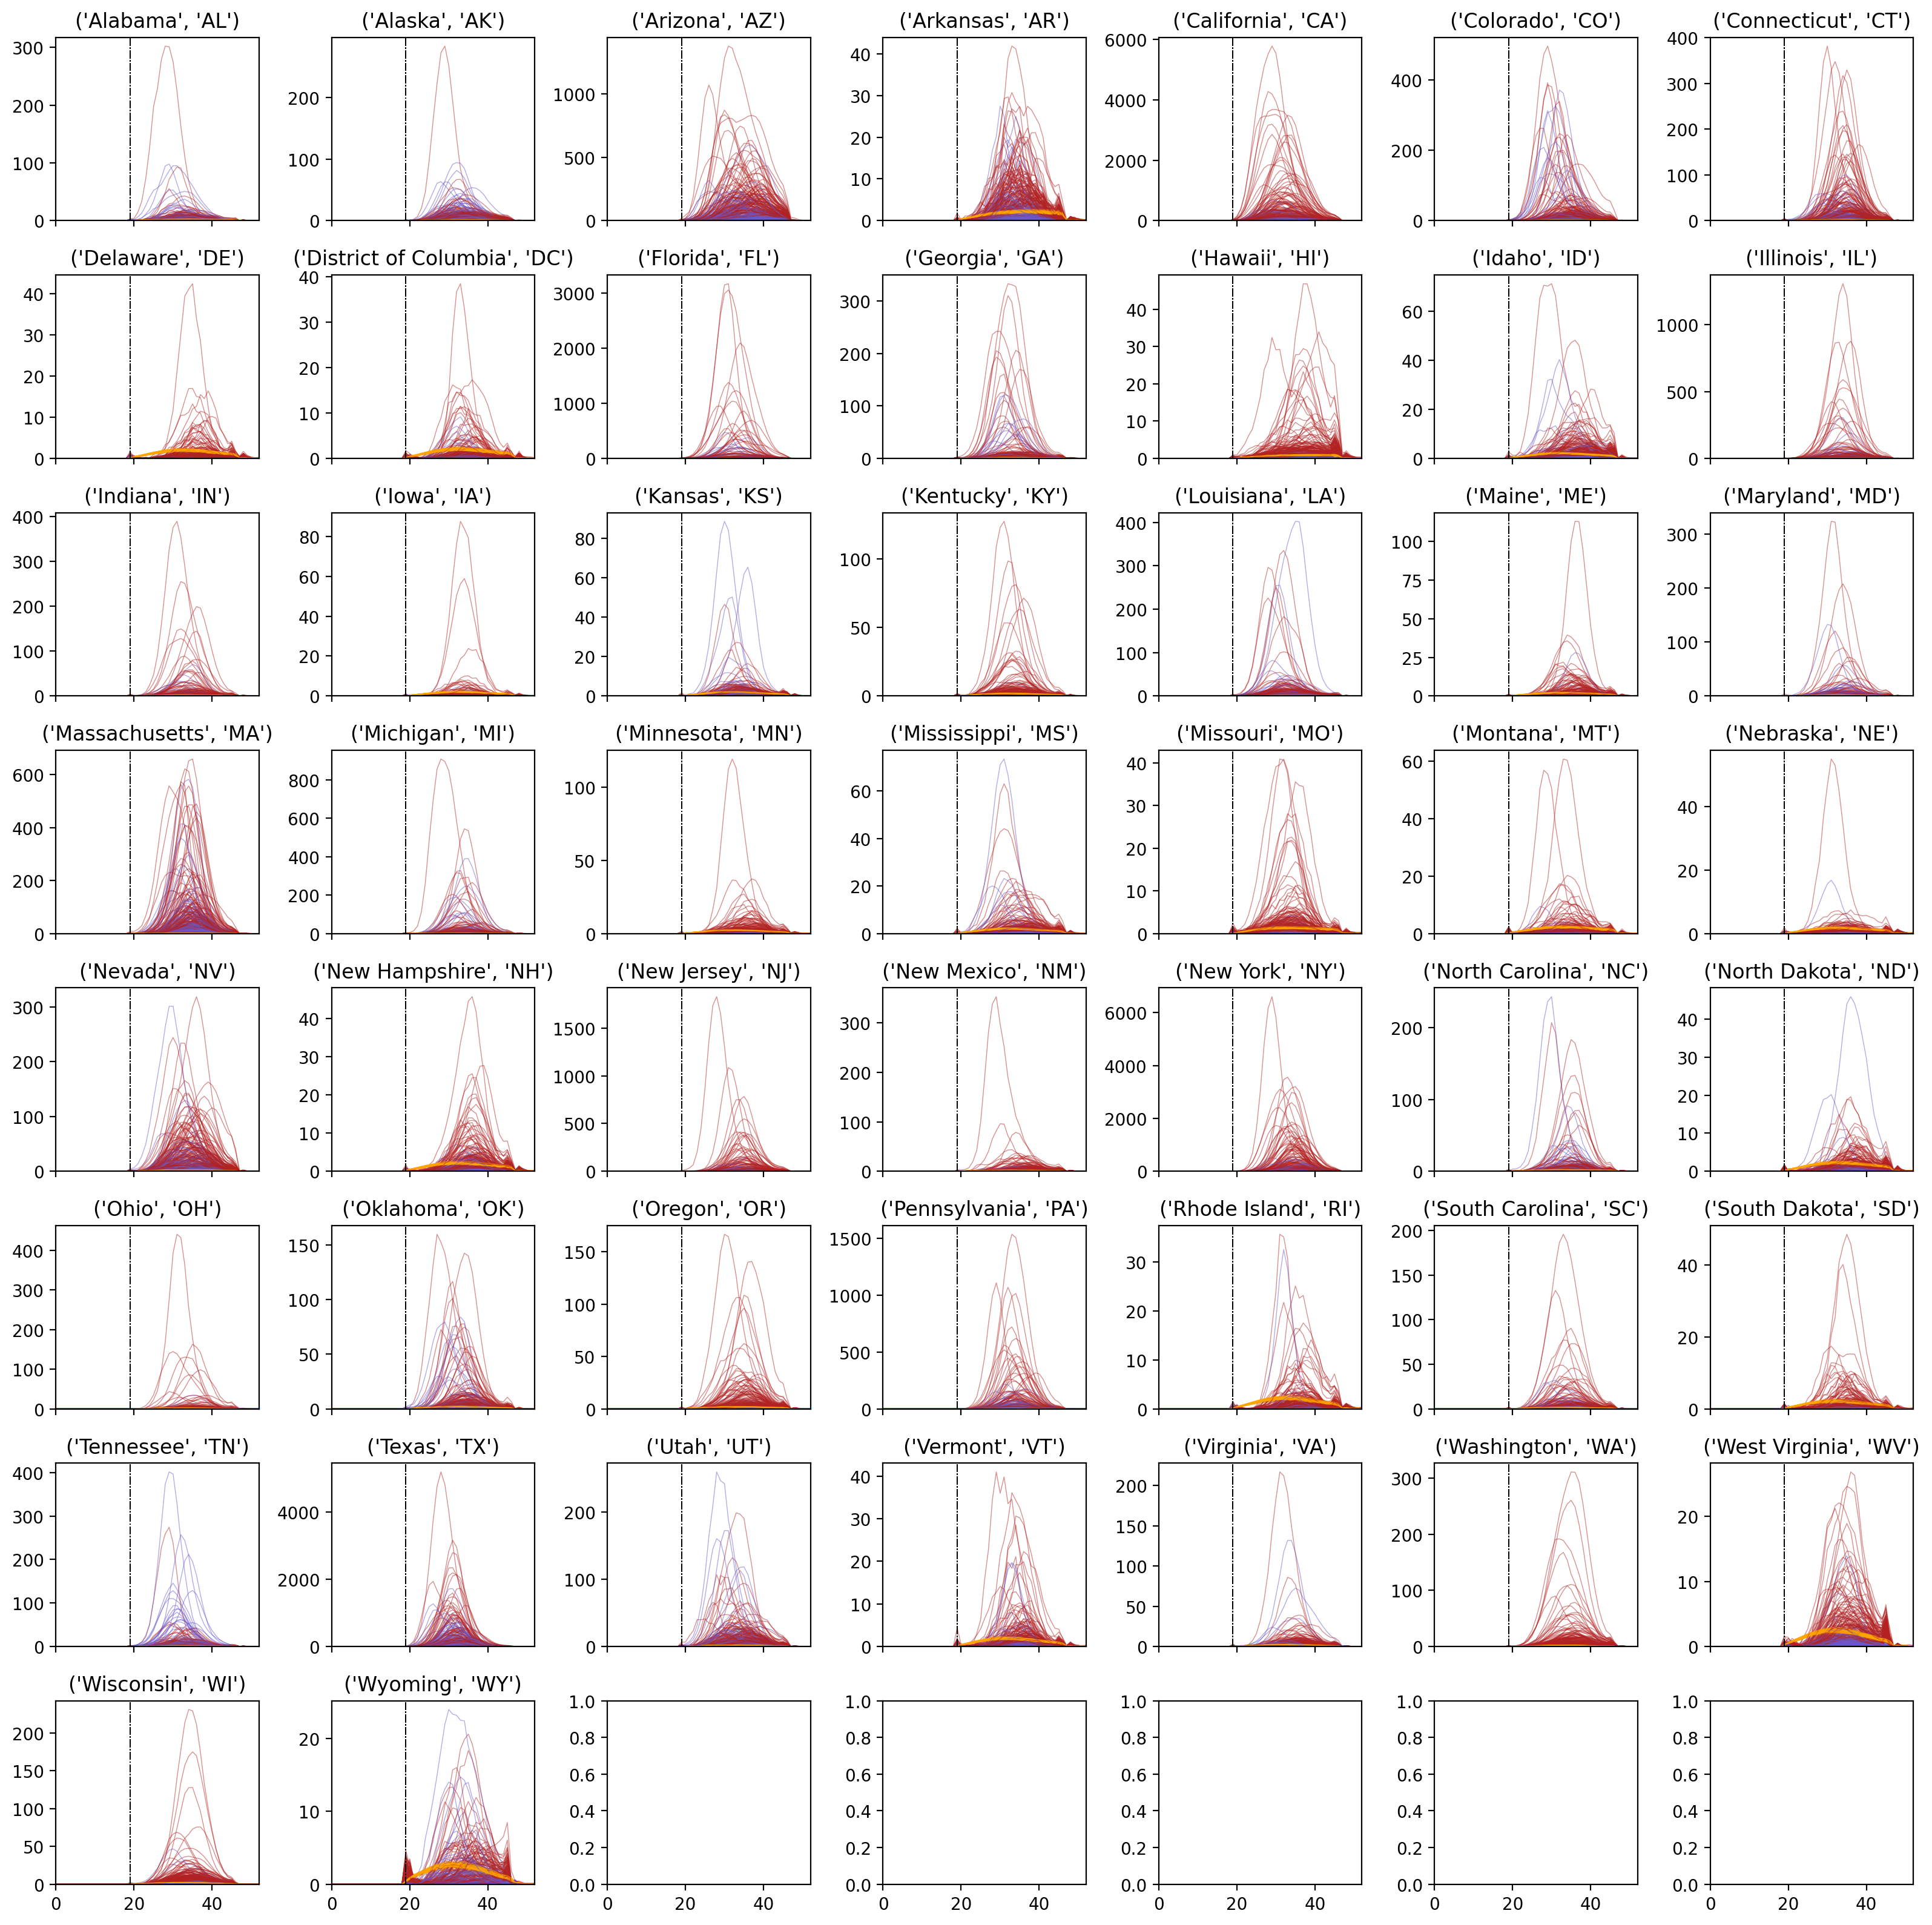

In [48]:
fig, axes = plt.subplots(8, 7, figsize=(16,16), dpi=200, sharex=True)

for ipl in range(51):
    ax = axes.flat[ipl]
    for i in range(batch_size):
        show_tensor_image(samples[-1][i], ax = ax, place=ipl, multi=True)
        ax.axvline(gt_index, c='k', lw=.7, ls='-.')
        ax.set_xlim(0,52)
        ax.set_ylim(bottom=0, auto=True)
        ax.grid()
        ax.set_title(get_state_name(places[ipl]))
fig.tight_layout()
plt.savefig("inpainting.pdf")

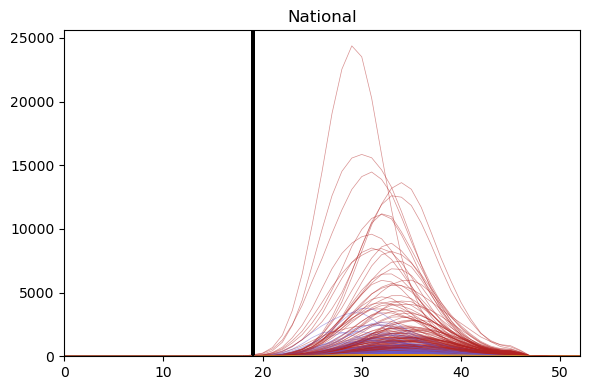

In [49]:
fig, axes = plt.subplots(1, 1, figsize=(6,4), dpi=100, sharex=True)

ax = axes
for i in range(batch_size):
    show_tensor_image(samples[-1][i], ax = ax, multi=True)
    ax.axvline(gt_index, c='k')
    ax.set_xlim(0,52)
    ax.set_ylim(bottom=0, auto=True)
    #ax.grid(visible = True)
    ax.set_title("National")
fig.tight_layout()
plt.show()